# Machine Problem  1 - Path Planning
 **Cruz, Rianna**   
 **Leal, Lois Anne**

## Problem Description: 
Consider the problem of finding the shortest path between two points on a plane that has polygonal obstacles. This is an idealization of the problem a robot has to solve to navigate it way around a crowded environment.

## Solution Proper:

### 1. Setting up state space

In [1]:
import re

def read_input(filename):
    file = open (filename, 'r+', encoding='utf-8')
    point = r'([\d]+,[\d]+)'

    start = tuple(map(int, re.search(point, file.readline())[0].split(',')))
    goal  = tuple(map(int, re.search(point, file.readline())[0].split(',')))

    shapes = []
    for line in file:
        shape = []
        for point_i in re.findall(point, line):
            point_int = map(int, point_i.split(','))
            shape.append(list(point_int))
        shapes.append(shape)

    file.close()
    return start, goal, shapes

In [2]:
import matplotlib.pyplot as plt

def plot_polygon(coord):
    coord.append(coord[0]) #repeat the first point to create a 'closed loop'
    xs, ys = zip(*coord) #create lists of x and y values
    plt.plot(xs,ys, linewidth=10) 

def plot_point(pt):
    plt.scatter(pt[0], pt[1], 30)

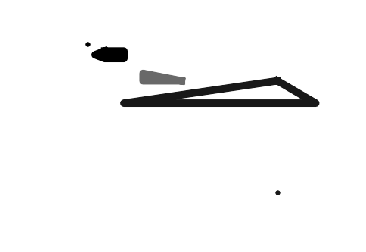

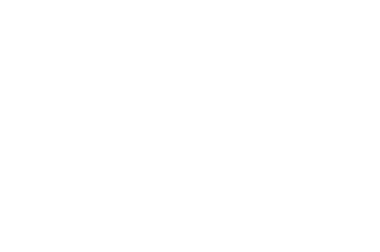

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

startNode, goalNode, shapes = read_input('in.txt')

plt.figure()
plt.gca().invert_yaxis()

for shape in shapes:
    plot_polygon(shape)

plot_point(startNode)
plot_point(goalNode)
plot_point((100, 200))

plt.axis('off')
plt.savefig('maze.png')
plt.clf() 

img = cv2.imread('maze.png', cv2.IMREAD_GRAYSCALE)
light = cv2.resize(img, (200, 100))

imgplot = plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.show()

plt.axis('off')
grid = np.zeros((100, 200))

for row, row_points in enumerate(light):
    for col, col_val in enumerate(row_points):
        if col_val < 255:
            grid[row][col] = 1

### 3. Convert from Grid to Graph Dictionary

This does the trick. For each cell in the grid, we see them as nodes of the graph. In the code below, what it does is that, for each node in the grid, we consider as a parent node and its children as the possible moves which are left, right, top and bottom. 

Thus the format of the Graph Dictionary is:
parent: children

***Note***: Cells that belong to the side of the polygon obstacles are not included in the parent node and also in the children of the other nodes.

In [4]:
from collections import defaultdict 

def addEdge(graph,u,v): 
    graph[u].append(v)


def createGraph(grid):
    #get the size of the grid
    rows = len(grid) 
    cols = len(grid[0])

    graph = defaultdict(list) 
    
    for row in range(rows):
        for col in range(cols):
            # move only when there's a space to move in the direction
            # and the considered point is not a point in the obstacle side
        
            if col != 0 and grid[row][col]!=1:
                addEdge(graph,(row,col),(row,col-1)) #left
            
            if col < cols-1 and grid[row][col]!=1:
                addEdge(graph,(row,col),(row,col+1)) #right
            
            if row != 0 and grid[row][col]!=1:
                addEdge(graph,(row,col),(row-1,col)) #top
            
            if row < rows-1 and grid[row][col]!=1:
                addEdge(graph,(row,col),(row+1,col)) #bottom
    
    return graph

graph = createGraph(grid)  #create the graph dictionary

In [ ]:
#print graph 
for k,v in graph.items():
    print(k,':',v)

### 4. Search Algorithms

### I. Breadth-First Search(BFS) Implementation  

Given the starting and goal point, we are tasked to know the shortest solution path between those two points using the Breadth First Search Algorithm. 

It is solved by the ff:

**Data Structures**
We use two data structures:
   
   (1) *parent* is a dictionary to know the parent of the given node.
   
   (2) *fringe* is a queue.

**We proceed to the process:**

1.we append the starting node to the fringe

2.we explore while the fringe still has nodes
   
3.so we pop the first element of the fringe
   
4.put this to the expanded node
*Note:* we enable duplicates with the nodes such that an explored node may still be considered
  
5.We check if the node that is expanded is the goal. We stop if it is and if not, we continue
   
6.Since it's not the goal node, we look to its children
that is if the node is not in the fringe, we append it
to the fringe. 

**Caution! The Nature of Starting and Goal Point**

However, we need to consider the nature of starting and goal point in telling who's the parent and who's the child for backtracking purposes later to get the solution path if we reached the goal. 
     
So if the start point is found above or in the same row as the goal point, we will only assign the parent-child relationship such that only those who are in the higher rows or
in the same row can parent but not those who are below them can parent the ones above. 

On the other hand, if the start point is found below or in the same row as the goal point,
we will only assign the parent-child relationship such that only those who are in the lower rows or in the same row can parent but not those who are above them can parent the ones below. 

***Why?***

Since we are considering graphs, it is possible to have cycles. If we do not include those conditions, there will come a time that the above node can parent the below and the below can parent the above, thus if we backtrack say (3,0) is the parent of (4,0), then it would ask, who is the parent of (3,0) then we will find that it is (4,0) and it will just loop forever--which we do not want to happen.

We implement this solution in the code below:

In [5]:
import time
start = time.time()

expandedNode = []

def backtrace(parent, start, end):
    path = [end]
    while path[-1] != start:
        add = parent[path[-1]]
        path.append(add)
    path.reverse()
    return path
      
def bfs(graph, start, goal):
    parent = {} 
    fringe = [] 
    fringe.append(start) #append starting node
    
    while fringe: #explore til the fringe is not empty!
        node = fringe.pop(0) #get vertex
        expandedNode.append(node) #append the considered vertex to the Expanded Nodes
        if node == goal: #if reaches goal node
            return backtrace(parent, start, goal)
        for adjacent in graph.get(node, []): #consider the children of the popped node 
            if node not in fringe:     
                if start[0]<=goal[0]:
                  if adjacent[0] >= node[0]:
                    parent[adjacent] = node  
                if start[0]>=goal[0]:
                    if adjacent[0] <= node[0]:
                      parent[adjacent] = node  
                fringe.append(adjacent) 

print("starting point:", startNode)
print("goal point:", goalNode)
path=bfs(graph, startNode, goalNode)
print("solution Path:",path)
print("cost of the solution:", len(path))
print("number of expanded nodes:",len(expandedNode))
end = time.time()
print("actual running time of the program:", end - start)

starting point: (1, 1)
goal point: (10, 10)
solution Path: [(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (10, 10)]
cost of the solution: 19
number of expanded nodes: 2721
actual running time of the program: 0.04115629196166992


**Seeing the solution path visually we have**

note to Lois and Ri! insert below the plot of solution path and the state space

From sir carlo: Describe and show the diagram/picture of the input files that you have created and the solution path generated

In [ ]:
#just edit this to show the path in the grid 
gridResultBFS = grid #Be sure to do this! We still want to reuse the statespace in the next algos
for (i,j) in path:
    gridResultBFS[i][j]= '*'
print(grid) #change this to plot!!!

### II. Depth-First Search(DFS) Implementation  

Given the starting and goal point, we are tasked to know the shortest solution path between those two points using the Depth-First Search Algorithm. 

It is solved by the ff:

**Data Structures**
We use two data structures:
   
   (1) *path* is a dictionary to know the parent of the given node.
   
   (2) *visited* is a queue.

   (3) *fringe* is a priority queue. 
   
**We proceed to the process:**

1.we put the starting node in the fringe with priority 0

2.we explore while the fringe still has nodes
   
3.so we pop the first element of the fringe which has the highest priority
   
4.put this to the expanded node
  
5.We check if the node that is expanded is the goal. We stop if it is and if not, we continue

6.Since it's not the goal node, we look to its children
that is if the node is not in the fringe, we append it
to the fringe. 

7.Since in working with dfs, the fringe does the trick, we assign the priority depending on the depth of the node. We put the negative sign so that we consider them first as this is dfs. 
This also let us not use anymore the parent dictionary. 


We implement this solution in the code below:

In [6]:
from queue import PriorityQueue
from collections import defaultdict 
import time

start = time.time()
expandedNode = []


def dfs(graph, startNode, goalNode):
    path = [startNode]
    visited = []
    fringe = PriorityQueue()
    fringe.put((0, startNode, path, visited))

    while fringe:
        depth, currentNode, path, visited = fringe.get()
        
        expandedNode.append(currentNode)

        if currentNode == goalNode: 
            return path + [currentNode]
          
        if currentNode not in visited:
          visited = visited + [currentNode]

        for node in graph[currentNode]: #look at the children
            if node not in visited:
                if node == goalNode:
                    expandedNode.append(node)
                    return path + [node]               
                fringe.put((-len(path), node, path + [node], visited + [node]))
    return path 

print("starting point:", startNode)
print("goal point:", goalNode)
path= dfs(graph, startNode, goalNode)
print("solution path:", path) 
print("cost of the solution:", len(path))
print("number of expanded nodes:",len(expandedNode))
end = time.time()
print("actual running time of the program:", end - start)


starting point: (1, 1)
goal point: (10, 10)
solution path: [(1, 1), (0, 1), (0, 0), (1, 0), (2, 0), (2, 1), (2, 2), (1, 2), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (0, 47), (0, 48), (0, 49), (0, 50), (0, 51), (0, 52), (0, 53), (0, 54), (0, 55), (0, 56), (0, 57), (0, 58), (0, 59), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 65), (0, 66), (0, 67), (0, 68), (0, 69), (0, 70), (0, 71), (0, 72), (0, 73), (0, 74), (0, 75), (0, 76), (0, 77), (0, 78), (0, 79), (0, 80), (0, 81), (0, 82), (0, 83), (0, 84), (0, 85), (0, 86), (0, 87), (0, 88), (0, 89), (0, 90), (0, 91), (0, 92), (0, 93), (0, 94), (0, 95), (0, 96), (0, 97), (0, 98), (0, 99), (0

**Seeing the solution path visually we have**

note to Lois and Ri! insert below the plot of solution path and the state space

From sir carlo: Describe and show the diagram/picture of the input files that you have created and the solution path generated

In [ ]:
#just edit this to show the path in the grid 
gridResultDFS = grid #Be sure to do this! We still want to reuse the statespace in the next algos
for (i,j) in path:
    gridResultDFS[i][j]= '*'
print(grid) #change this to plot!!!

### III. A* Implementation  

Given the starting and goal point, we are tasked to know the shortest solution path between those two points using the A* Algorithm. 

It is solved by the ff:

**Heuristic Function**

**Data Structures**
We use two data structures:
   
   (1) 
   
   (2) 

   (3) 
   
**We proceed to the process:**

1.

2.
   
3.
   
4.
  
5.

6.

7.


We implement this solution in the code below:

In [ ]:
insert code here for A*

**Seeing the solution path visually we have**

note to Lois and Ri! insert below the plot of solution path and the state space

From sir carlo: Describe and show the diagram/picture of the input files that you have created and the solution path generated

In [ ]:
#just edit this to show the path in the grid 
gridResultAstar = grid #Be sure to do this! We still want to reuse the statespace in the next algos
for (i,j) in path:
    gridResultAstar[i][j]= '*'
print(grid) #change this to plot!!!

## Analysis: 

Note to Lois and Ri from sir carlo!

An analysis and comparison of the different search methods based on relevant criteria, along with appropriate conclusions

#### Breadth-First Search Implementation



##### References:

https://codereview.stackexchange.com/questions/135156/bfs-implementation-in-python-3 

https://dbader.org/blog/priority-queues-in-python

https://medium.com/@lennyboyatzis/ai-teaching-pacman-to-search-with-depth-first-search-ee57daf889ab